In [3]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import plotly.express as px 

sb.set()

In [4]:
data = pd.read_csv('/Users/ajvj56/MyCSJournalAJVJ/spotify-2023.csv', encoding='ISO-8859-1')

feature_names = ["danceability_%", "valence_%", "energy_%", "acousticness_%", "instrumentalness_%", "speechiness_%"]

X = data[feature_names]

y = []
for stream in data["streams"]:
    if stream >= 1735441776:
        y.append(1)
    else:
        y.append(0)

y = pd.DataFrame(y)


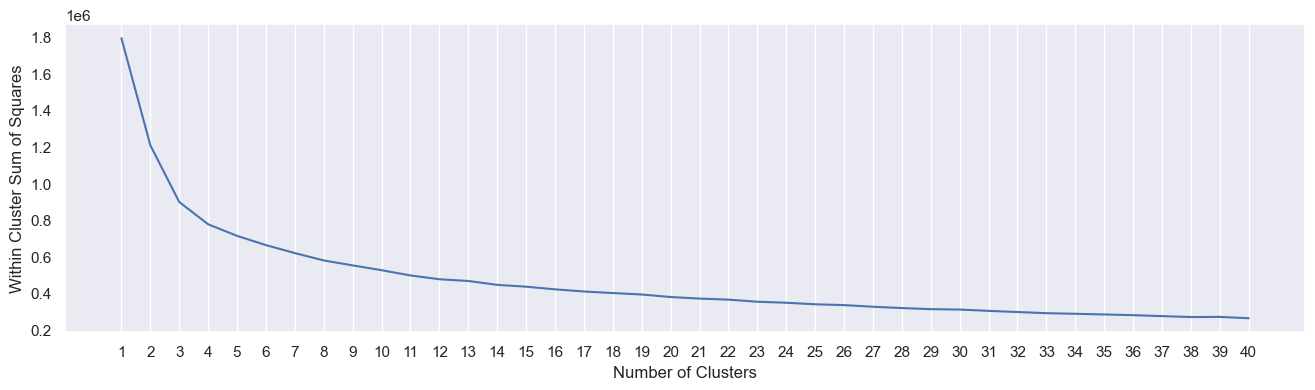

In [5]:
# Vary the Number of Clusters
min_clust = 1
max_clust = 40
init_algo = 'k-means++'

# Compute Within Cluster Sum of Squares
within_ss = []
for num_clust in range(min_clust, max_clust+1):
    kmeans = KMeans(n_clusters = num_clust, init = init_algo, n_init = 5)
    kmeans.fit(X)
    within_ss.append(kmeans.inertia_)

# Angle Plot : Within SS vs Number of Clusters
f, axes = plt.subplots(1, 1, figsize=(16,4))
plt.plot(range(min_clust, max_clust+1), within_ss)
plt.xlabel('Number of Clusters')
plt.ylabel('Within Cluster Sum of Squares')
plt.xticks(np.arange(min_clust, max_clust+1, 1.0))
plt.grid(which='major', axis='y')
plt.show()

In [6]:
# Set "optimal" Clustering Parameters
num_clust = 3
init_algo = 'k-means++'

# Create Clustering Model using KMeans
kmeans = KMeans(n_clusters = num_clust,         
               init = init_algo,
               n_init = 20)                 

# Fit the Clustering Model on the Data
kmeans.fit(X)

KMeans(n_clusters=3, n_init=20)

Features 	Streams 	danceability 	valence 	energy 		acousticness 	instrumentalness 	speechiness

Cluster 0:	63.72		33.87		65.97		12.15		2.32		10.45		
Cluster 1:	56.56		38.64		44.17		69.37		2.44		8.37		
Cluster 2:	74.53		72.44		71.87		21.0		0.55		10.67		

Within Cluster Sum of Squares : 897374.17420181



<Axes: xlabel='Cluster', ylabel='count'>

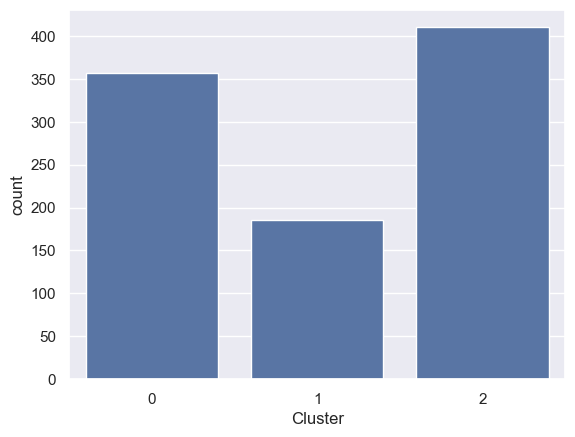

In [7]:
# Print the Cluster Centers
print("Features \tStreams \tdanceability \tvalence \tenergy \t\tacousticness \tinstrumentalness \tspeechiness")
print()

for i, center in enumerate(kmeans.cluster_centers_):
    print("Cluster", i, end=":\t")
    for coord in center:
        print(round(coord, 2), end="\t\t")
    print()
print()

# Print the Within Cluster Sum of Squares
print("Within Cluster Sum of Squares :", kmeans.inertia_)
print()

# Predict the Cluster Labels
labels = kmeans.predict(X)

# Append Labels to the Data
X_labeled = X.copy()
X_labeled["Cluster"] = pd.Categorical(labels)

# Summary of the Cluster Labels
sb.countplot(x=X_labeled["Cluster"])

In [8]:
song_cluster_pipeline = Pipeline([('scaler', StandardScaler()), 
                                  ('kmeans', KMeans(n_clusters=4, 
                                   verbose=False))
                                 ], verbose=False)

number_cols = list(X.columns)
song_cluster_pipeline.fit(X)
song_cluster_labels = song_cluster_pipeline.predict(X)
data['cluster_label'] = song_cluster_labels


In [9]:
# Visualizing the Clusters with PCA

from sklearn.decomposition import PCA

pca_pipeline = Pipeline([('scaler', StandardScaler()), ('PCA', PCA(n_components=2))])
song_embedding = pca_pipeline.fit_transform(X)
projection = pd.DataFrame(columns=['x', 'y'], data=song_embedding)
projection['title'] = data['track_name']
projection['cluster'] = data['cluster_label']

fig = px.scatter(
    projection, x='x', y='y', color='cluster', hover_data=['x', 'y', 'title'])
fig.show()

Train Accuracy: 0.8783783783783784
Test Accuracy: 0.9055944055944056

Classification Report (Test):
               precision    recall  f1-score   support

        High       0.00      0.00      0.00         5
         Low       0.91      1.00      0.95       259
      Medium       0.00      0.00      0.00        22

    accuracy                           0.91       286
   macro avg       0.30      0.33      0.32       286
weighted avg       0.82      0.91      0.86       286


Confusion Matrix (Test):
 [[  0   5   0]
 [  0 259   0]
 [  0  22   0]]


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



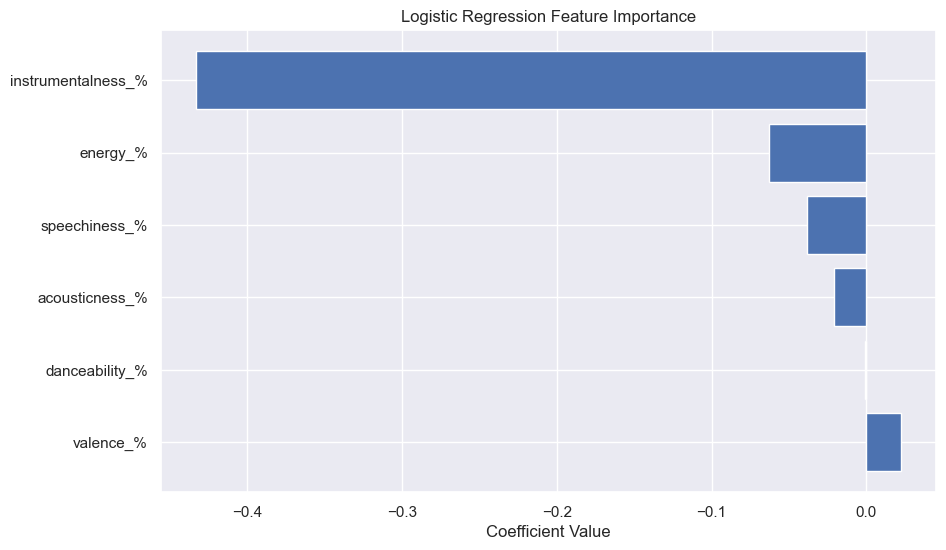

In [10]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Assuming numeric_data is your DataFrame
y = data["streams"]
X = data[["danceability_%", "valence_%", "energy_%", "acousticness_%", "instrumentalness_%", "speechiness_%"]]

# Convert continuous 'streams' into 3 categories (Low, Medium, High)
y = pd.cut(y, bins=3, labels=["Low", "Medium", "High"])

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize and train Logistic Regression
logreg = LogisticRegression(max_iter=1000, solver='liblinear')  # Increased max_iter for convergence
logreg.fit(X_train, y_train)

# Predictions
y_train_pred = logreg.predict(X_train)
y_test_pred = logreg.predict(X_test)

# Evaluate Model
print("Train Accuracy:", accuracy_score(y_train, y_train_pred))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))

print("\nClassification Report (Test):\n", classification_report(y_test, y_test_pred))
print("\nConfusion Matrix (Test):\n", confusion_matrix(y_test, y_test_pred))

# Plot Feature Importance (Coefficients)
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': logreg.coef_[0]
}).sort_values('Coefficient', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Coefficient'])
plt.xlabel('Coefficient Value')
plt.title('Logistic Regression Feature Importance')
plt.show()

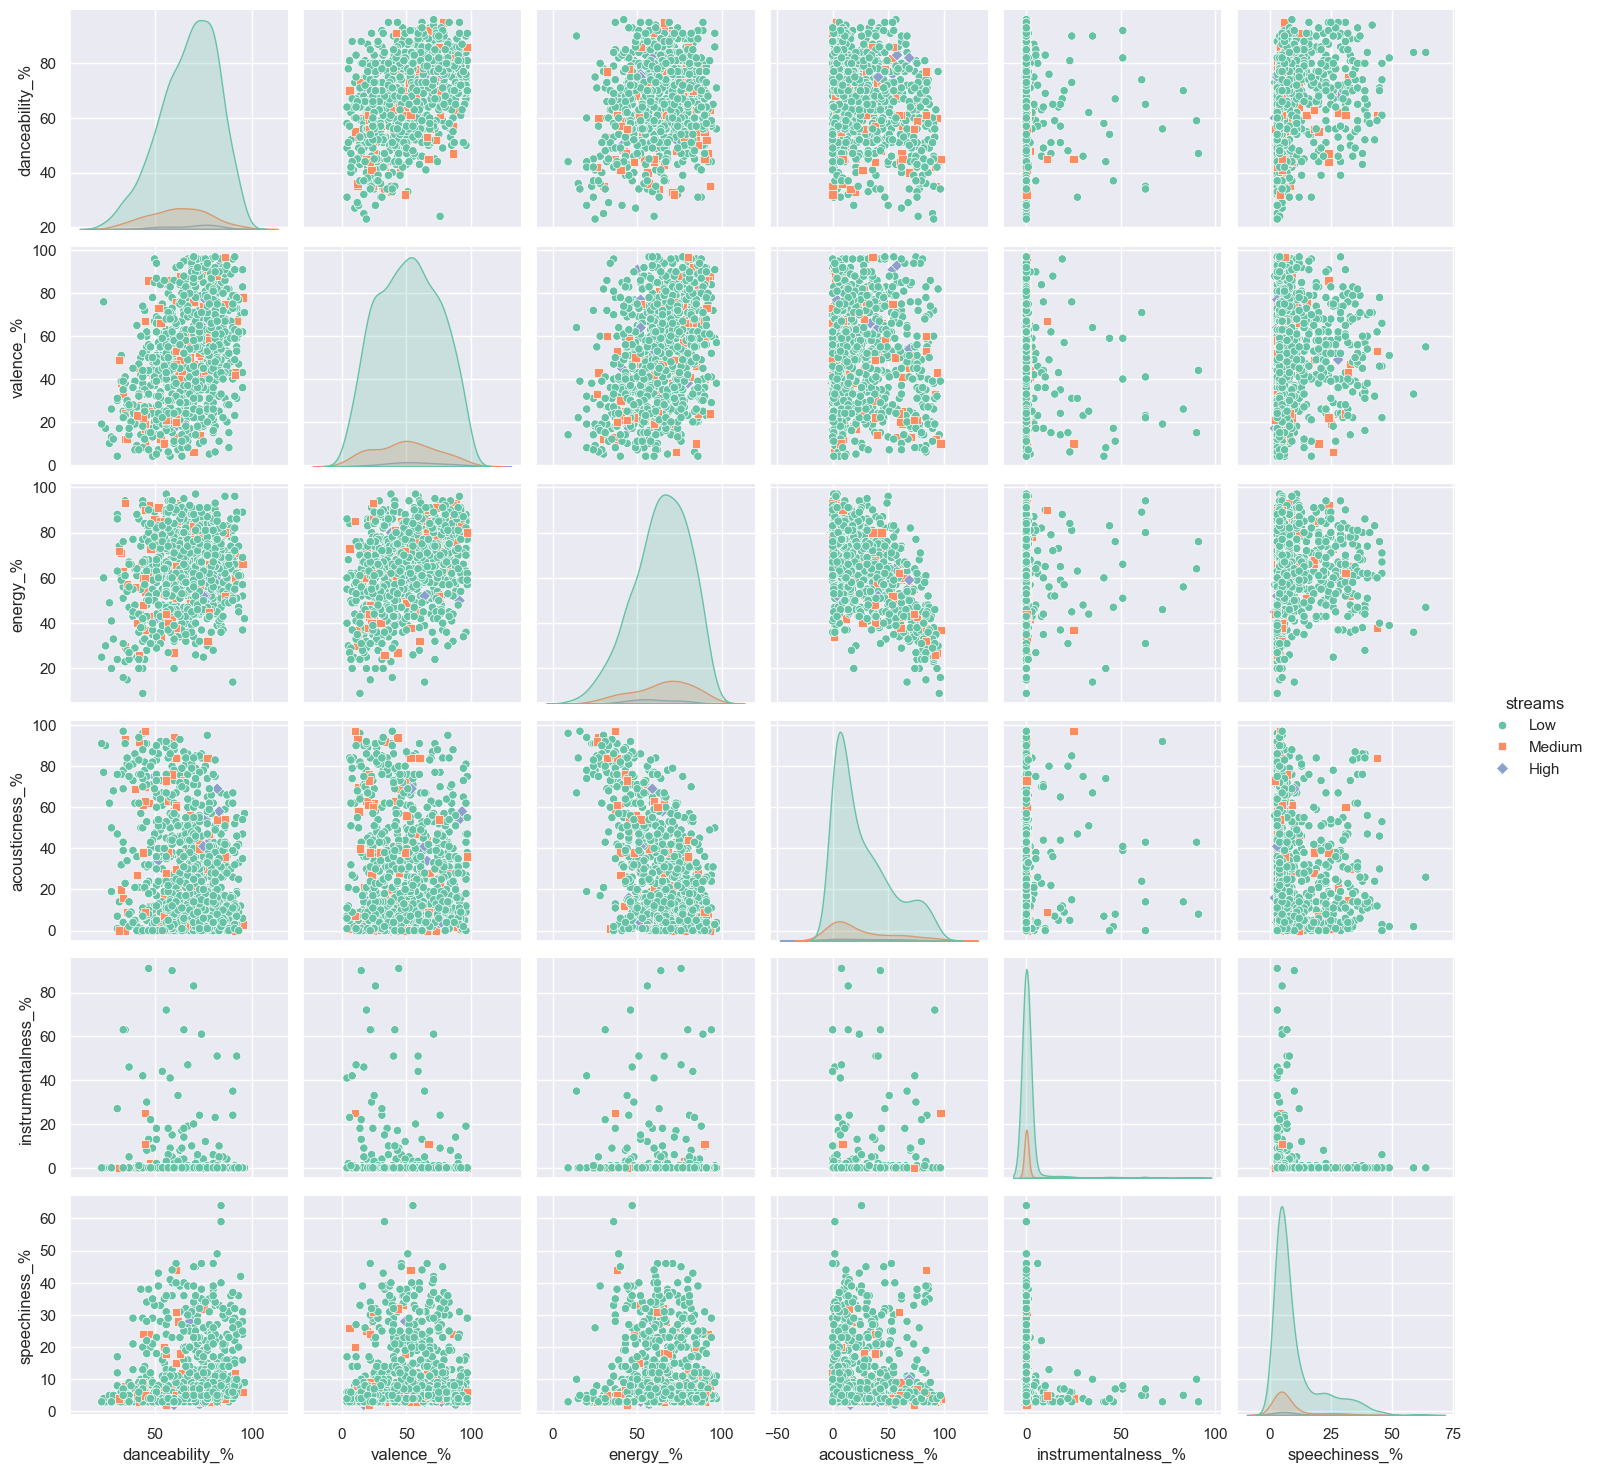

In [11]:
import seaborn as sns

# Combine features and target for plotting
data_with_target = X.copy()
data_with_target['streams'] = y

# Plot pairplot
sns.pairplot(data_with_target, hue="streams", markers=["o", "s", "D"], palette="Set2")
plt.show()